**1. IMPORT LIBRARIES**

In [ ]:
# 1. Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing and modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Deep learning frameworks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# System
import warnings
warnings.filterwarnings('ignore')


**2. LOADING & COMBINING THE DATASET**

In [ ]:
# STEP 1: Mount Google Drive
from google.colab import drive
import os
import pandas as pd

drive.mount('/content/drive')

# STEP 2: Set the path to the folder containing your dataset files (adjust to your folder name)
data_dir = "/content/drive/My Drive/diabetes_dataset"

# STEP 3: Get all file names that start with 'data-'
data_files = [f for f in os.listdir(data_dir) if f.startswith("data-")]

# STEP 4: Initialize a list to collect DataFrames
df_list = []

# STEP 5: Read and process each file
for file in data_files:
    file_path = os.path.join(data_dir, file)
    try:
        df = pd.read_csv(file_path, delimiter="\t", header=None, names=["Date", "Time", "Code", "Value"])
        df["Patient_ID"] = file
        df_list.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# STEP 6: Combine all patient data into a single DataFrame
final_df = pd.concat(df_list, ignore_index=True)

# STEP 7: Parse the date and time columns into a single datetime column
final_df["Datetime"] = pd.to_datetime(final_df["Date"] + " " + final_df["Time"], errors="coerce")
final_df.drop(columns=["Date", "Time"], inplace=True)

# STEP 8: Drop rows with invalid datetime or invalid glucose readings
final_df.dropna(subset=["Datetime"], inplace=True)
final_df["Value"] = pd.to_numeric(final_df["Value"], errors="coerce")
final_df = final_df[final_df["Value"] > 0]

# STEP 9: Sort chronologically and reset index
final_df.sort_values(by="Datetime", inplace=True)
final_df.reset_index(drop=True, inplace=True)

# STEP 10: Optional – preview the structure
print(f"Total records: {len(final_df)}")
final_df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total records: 27979


,Code,Value,Patient_ID,Datetime
0,58,134.0,data-68,1988-03-27 08:00:00
1,34,20.0,data-68,1988-03-27 08:00:00
2,60,158.0,data-68,1988-03-27 12:00:00
3,62,258.0,data-68,1988-03-27 18:00:00
4,58,115.0,data-68,1988-03-28 08:00:00


**3A. EDA: Event Frequency (Bar Chart + Table)**

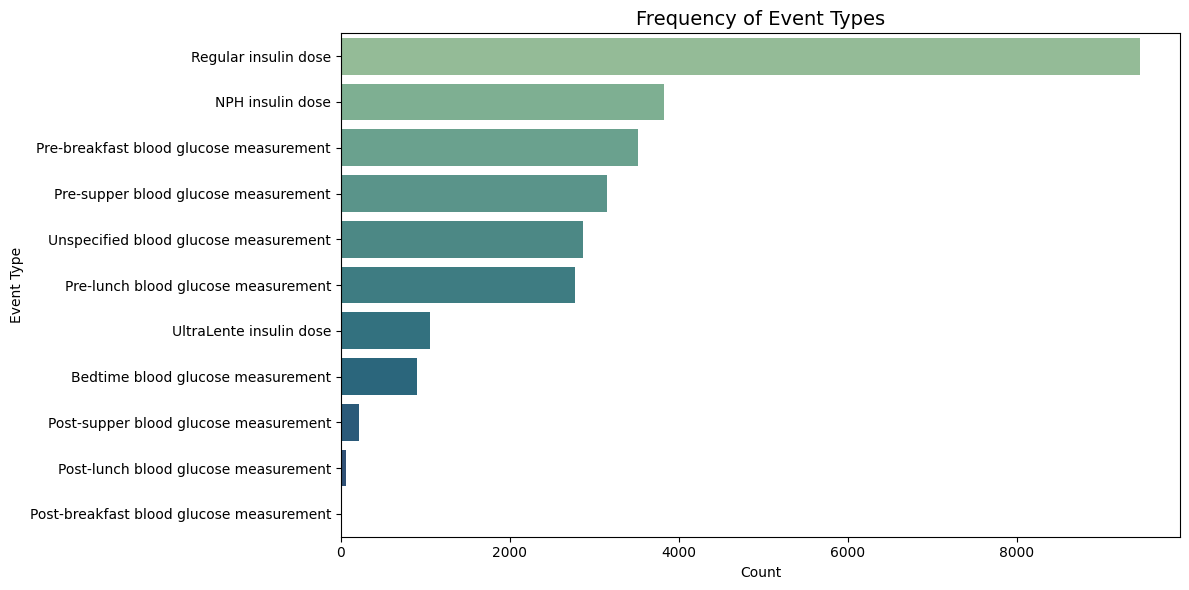

,count
Event,
Regular insulin dose,9461
NPH insulin dose,3828
Pre-breakfast blood glucose measurement,3516
Pre-supper blood glucose measurement,3156
Unspecified blood glucose measurement,2870
Pre-lunch blood glucose measurement,2767
UltraLente insulin dose,1053
Bedtime blood glucose measurement,903
Post-supper blood glucose measurement,219


In [ ]:
# STEP 1: Define code-to-event mapping (same as before)
code_mapping = {
    33: 'Regular insulin dose',
    34: 'NPH insulin dose',
    35: 'UltraLente insulin dose',
    48: 'Unspecified blood glucose measurement',
    57: 'Unspecified blood glucose measurement',
    58: 'Pre-breakfast blood glucose measurement',
    59: 'Post-breakfast blood glucose measurement',
    60: 'Pre-lunch blood glucose measurement',
    61: 'Post-lunch blood glucose measurement',
    62: 'Pre-supper blood glucose measurement',
    63: 'Post-supper blood glucose measurement',
    64: 'Bedtime blood glucose measurement',
    65: 'Hypoglycemic symptoms',
    66: 'Typical meal ingestion',
    67: 'More-than-usual meal ingestion',
    68: 'Less-than-usual meal ingestion',
    69: 'Typical exercise activity',
    70: 'More-than-usual exercise activity',
    71: 'Less-than-usual exercise activity',
    72: 'Unspecified special event'
}

# STEP 2: Add a new column for human-readable event labels
final_df["Event"] = final_df["Code"].map(code_mapping)

# STEP 3: Event frequency table
event_counts = final_df["Event"].value_counts()

# STEP 4: Plot bar chart of event frequencies
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=event_counts.values, y=event_counts.index, palette="crest")
plt.title("Frequency of Event Types", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

# STEP 5: Display frequency table
event_counts


**3B. Glucose Level Distribution**

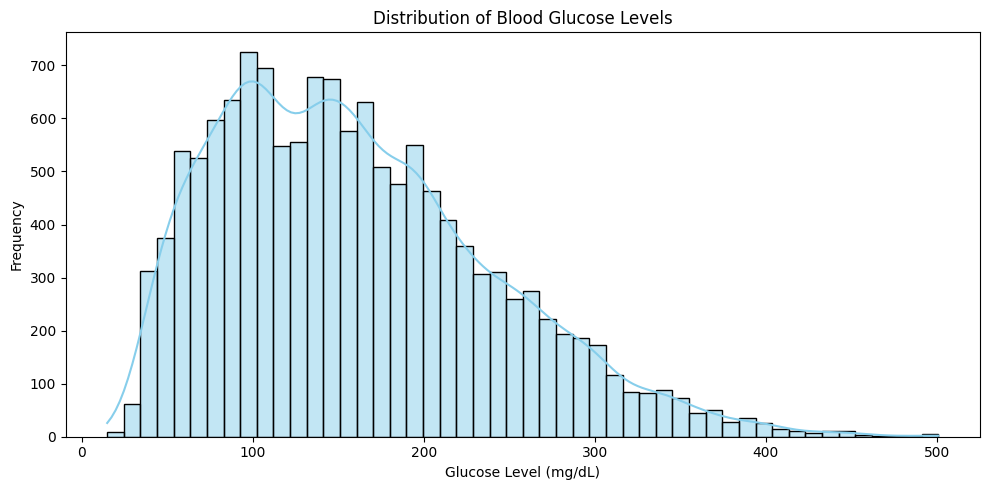

,Value
count,13517.000000
mean,160.258267
std,80.160466
min,15.000000
25%,97.000000
50%,149.000000
75%,210.000000
max,501.000000


In [ ]:
# Filter only glucose-related events (code between 57–64 range usually indicates glucose tests)
glucose_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
glucose_df = final_df[final_df["Code"].isin(glucose_codes)]

# Plot histogram of glucose values
plt.figure(figsize=(10, 5))
sns.histplot(glucose_df["Value"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Blood Glucose Levels")
plt.xlabel("Glucose Level (mg/dL)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Show some stats
glucose_df["Value"].describe()


**Stage 4A: Creating Sliding Windows for Time-Series Modeling**

In [ ]:
import numpy as np

# Step 1: Filter for glucose measurements only
glucose_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
glucose_df = final_df[final_df["Code"].isin(glucose_codes)].copy()
glucose_df.sort_values("Datetime", inplace=True)

# Step 2: Reset index for safe slicing
glucose_df.reset_index(drop=True, inplace=True)

# Step 3: Only keep glucose values (and optionally timestamps for later plotting)
values = glucose_df["Value"].values

# Step 4: Create sequences using sliding window
def create_sequences(data, window_size=3):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Step 5: Apply it with a window of 3
window_size = 3
X, y = create_sequences(values, window_size=window_size)

# Step 6: Check shapes
print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")


Input shape (X): (13514, 3)
Target shape (y): (13514,)


**Stage 4B: Normalize + Split into Train/Test**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Step 1: Scale X and y separately
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

# Step 2: Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Step 3: Confirm shapes
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


X_train: (10811, 3)
X_test : (2703, 3)
y_train: (10811, 1)
y_test : (2703, 1)


**Code Block: MLP Model for Glucose Prediction**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Define the MLP model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer (regression)
])

# Step 2: Compile the model
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 3: Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = mlp_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0501 - mae: 0.1722 - val_loss: 0.0279 - val_mae: 0.1343
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0254 - mae: 0.1277 - val_loss: 0.0277 - val_mae: 0.1340
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0255 - mae: 0.1280 - val_loss: 0.0278 - val_mae: 0.1340
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0251 - mae: 0.1269 - val_loss: 0.0280 - val_mae: 0.1372
Epoch 5/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - mae: 0.1286 - val_loss: 0.0278 - val_mae: 0.1341
Epoch 6/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0248 - mae: 0.1260 - val_loss: 0.0277 - val_mae: 0.1346
Epoch 7/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0248 - mae: 0.1259 - val_loss: 0.0280 - val_mae: 0.1332
Epoch 8/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259 - mae: 0.1279 - val_loss: 0.0279 - val_mae: 0.1341
Epoch 9/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

**Evaluate + Visualize MLP Predictions**

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP Test MSE: 7360.91
MLP Test MAE: 69.25
MLP Test R² : -0.00


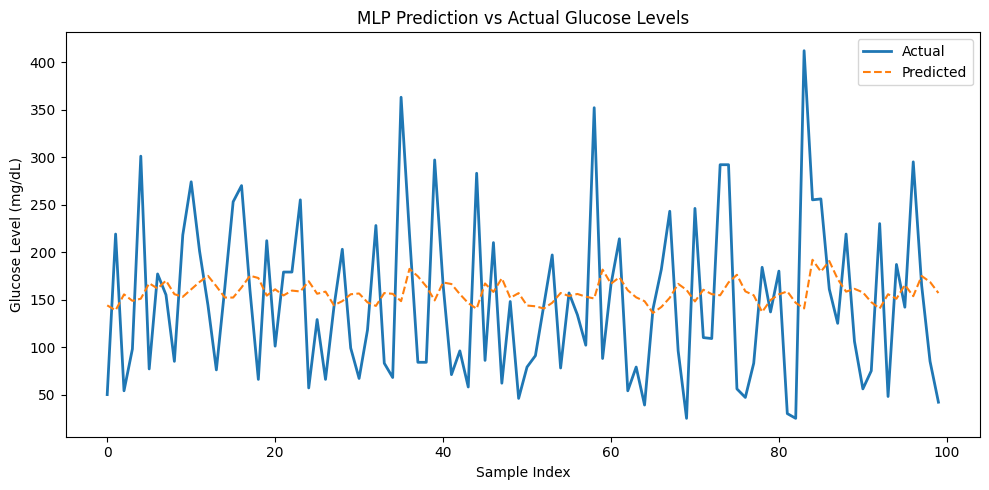

In [19]:
# Step 1: Predict on test set
y_pred_scaled = mlp_model.predict(X_test)

# Step 2: Inverse scale to original glucose values
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

# Step 3: Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MLP Test MSE: {mse:.2f}")
print(f"MLP Test MAE: {mae:.2f}")
print(f"MLP Test R² : {r2:.2f}")

# Step 4: Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_true[:100], label="Actual", linewidth=2)
plt.plot(y_pred[:100], label="Predicted", linestyle="--")
plt.title("MLP Prediction vs Actual Glucose Levels")
plt.xlabel("Sample Index")
plt.ylabel("Glucose Level (mg/dL)")
plt.legend()
plt.tight_layout()
plt.show()


**LSTM Model: Deep Learning for Time-Based Prediction**

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Reshape input for LSTM [samples, time_steps, features]
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 2: Define LSTM model
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Step 3: Compile model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 4: Train model
history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)


Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0381 - mae: 0.1509 - val_loss: 0.0277 - val_mae: 0.1344
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0254 - mae: 0.1280 - val_loss: 0.0276 - val_mae: 0.1342
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0253 - mae: 0.1268 - val_loss: 0.0277 - val_mae: 0.1345
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0247 - mae: 0.1253 - val_loss: 0.0278 - val_mae: 0.1363
Epoch 5/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0254 - mae: 0.1269 - val_loss: 0.0276 - val_mae: 0.1344
Epoch 6/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0255 - mae: 0.1276 - val_loss: 0.0282 - val_mae: 0.1335
Epoch 7/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0257 - mae: 0.1282 - val_loss: 0.0279 - val_mae: 0.1336
Epoch 8/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0258 - mae: 0.1284 - val_loss: 0.0278 - val_mae: 0.1360
Epoch 9/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/

**Evaluate & Plot LSTM Predictions**

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Test MSE: 7324.47
LSTM Test MAE: 69.33
LSTM Test R² : 0.00


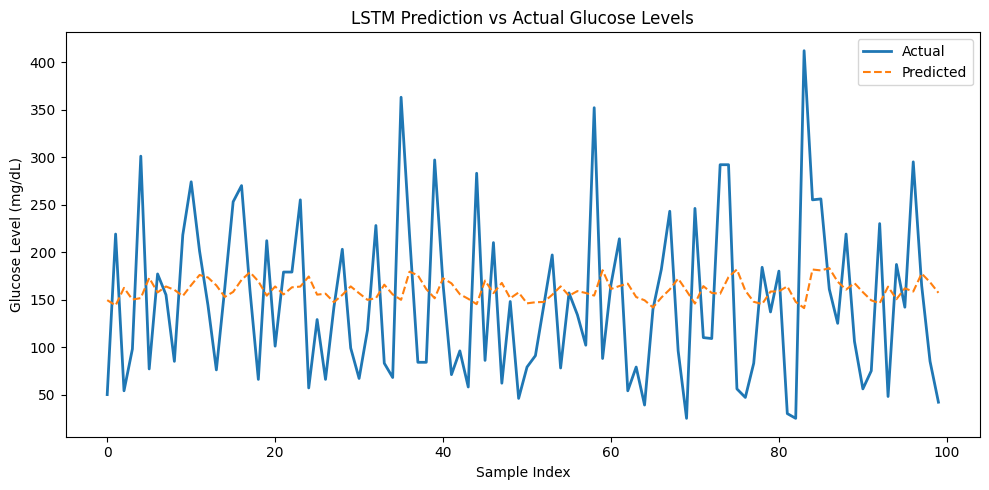

In [21]:
# Step 1: Predict
y_pred_lstm_scaled = lstm_model.predict(X_test_lstm)
y_pred_lstm = y_scaler.inverse_transform(y_pred_lstm_scaled)
y_true_lstm = y_scaler.inverse_transform(y_test)

# Step 2: Metrics
mse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm)
mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm)
r2_lstm = r2_score(y_true_lstm, y_pred_lstm)

print(f"LSTM Test MSE: {mse_lstm:.2f}")
print(f"LSTM Test MAE: {mae_lstm:.2f}")
print(f"LSTM Test R² : {r2_lstm:.2f}")

# Step 3: Plot predictions vs actual
plt.figure(figsize=(10, 5))
plt.plot(y_true_lstm[:100], label="Actual", linewidth=2)
plt.plot(y_pred_lstm[:100], label="Predicted", linestyle="--")
plt.title("LSTM Prediction vs Actual Glucose Levels")
plt.xlabel("Sample Index")
plt.ylabel("Glucose Level (mg/dL)")
plt.legend()
plt.tight_layout()
plt.show()


**Build & Train the GRU Model**

In [22]:
from tensorflow.keras.layers import GRU

# Step 1: Reuse reshaped LSTM input
# X_train_lstm and X_test_lstm are already shaped as (samples, timesteps, features)

# Step 2: Define GRU model
gru_model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Step 3: Compile GRU model
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 4: Train the model
history_gru = gru_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)


Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0397 - mae: 0.1544 - val_loss: 0.0277 - val_mae: 0.1350
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0256 - mae: 0.1274 - val_loss: 0.0277 - val_mae: 0.1344
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0253 - mae: 0.1268 - val_loss: 0.0277 - val_mae: 0.1339
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0252 - mae: 0.1267 - val_loss: 0.0278 - val_mae: 0.1351
Epoch 5/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0259 - mae: 0.1281 - val_loss: 0.0278 - val_mae: 0.1336
Epoch 6/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0246 - mae: 0.1259 - val_loss: 0.0282 - val_mae: 0.1334
Epoch 7/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0258 - mae: 0.1284 - val_loss: 0.0277 - val_mae: 0.1346
Epoch 8/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0252 - mae: 0.1272 - val_loss: 0.0276 - val_mae: 0.1348
Epoch 9/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

**GRU Evaluation Code**

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
GRU Test MSE: 7329.12
GRU Test MAE: 69.44
GRU Test R² : 0.00


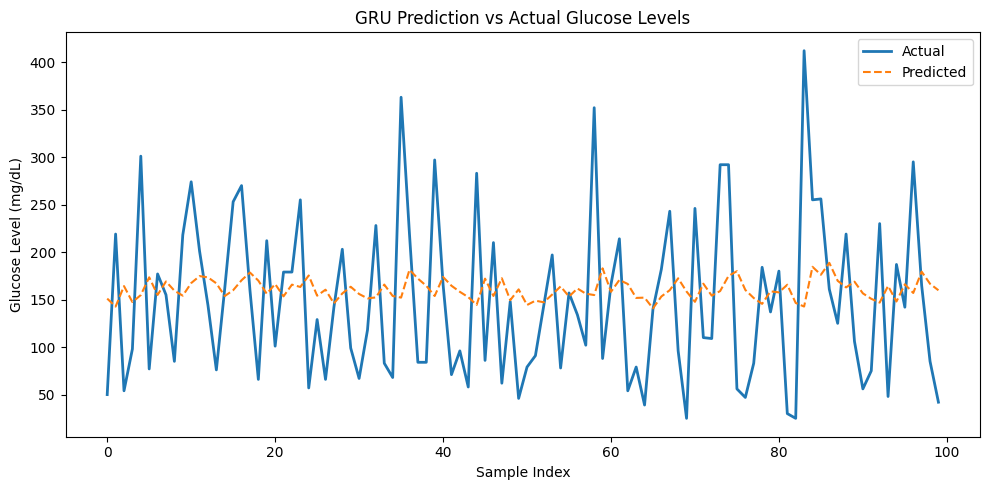

In [23]:
# Step 1: Predict on test set
y_pred_gru_scaled = gru_model.predict(X_test_lstm)
y_pred_gru = y_scaler.inverse_transform(y_pred_gru_scaled)
y_true_gru = y_scaler.inverse_transform(y_test)

# Step 2: Evaluate
mse_gru = mean_squared_error(y_true_gru, y_pred_gru)
mae_gru = mean_absolute_error(y_true_gru, y_pred_gru)
r2_gru = r2_score(y_true_gru, y_pred_gru)

print(f"GRU Test MSE: {mse_gru:.2f}")
print(f"GRU Test MAE: {mae_gru:.2f}")
print(f"GRU Test R² : {r2_gru:.2f}")

# Step 3: Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true_gru[:100], label="Actual", linewidth=2)
plt.plot(y_pred_gru[:100], label="Predicted", linestyle="--")
plt.title("GRU Prediction vs Actual Glucose Levels")
plt.xlabel("Sample Index")
plt.ylabel("Glucose Level (mg/dL)")
plt.legend()
plt.tight_layout()
plt.show()


**CNN Model for Glucose Forecasting**

In [26]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Step 1: Reuse LSTM-shaped data (samples, timesteps, features)
# We already have: X_train_lstm and X_test_lstm

# Step 2: Define CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

# Step 3: Compile
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 4: Train
history_cnn = cnn_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)


Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0319 - mae: 0.1389 - val_loss: 0.0292 - val_mae: 0.1406
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0259 - mae: 0.1290 - val_loss: 0.0279 - val_mae: 0.1350
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0257 - mae: 0.1282 - val_loss: 0.0278 - val_mae: 0.1353
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0252 - mae: 0.1269 - val_loss: 0.0281 - val_mae: 0.1368
Epoch 5/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253 - mae: 0.1272 - val_loss: 0.0283 - val_mae: 0.1337
Epoch 6/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0250 - mae: 0.1270 - val_loss: 0.0280 - val_mae: 0.1362
Epoch 7/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0256 - mae: 0.1278 - val_loss: 0.0289 - val_mae: 0.1341
Epoch 8/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0262 - mae: 0.1292 - val_loss: 0.0277 - val_mae: 0.1345
Epoch 9/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

**CNN Evaluation + Visualization Code**

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CNN Test MSE: 7355.52
CNN Test MAE: 69.32
CNN Test R² : 0.00


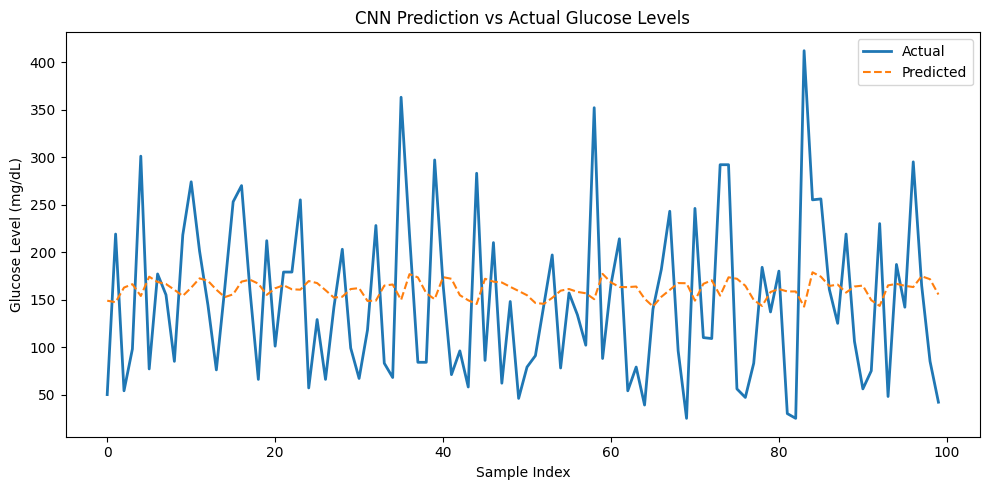

In [27]:
# Step 1: Predict
y_pred_cnn_scaled = cnn_model.predict(X_test_lstm)
y_pred_cnn = y_scaler.inverse_transform(y_pred_cnn_scaled)
y_true_cnn = y_scaler.inverse_transform(y_test)

# Step 2: Evaluate
mse_cnn = mean_squared_error(y_true_cnn, y_pred_cnn)
mae_cnn = mean_absolute_error(y_true_cnn, y_pred_cnn)
r2_cnn = r2_score(y_true_cnn, y_pred_cnn)

print(f"CNN Test MSE: {mse_cnn:.2f}")
print(f"CNN Test MAE: {mae_cnn:.2f}")
print(f"CNN Test R² : {r2_cnn:.2f}")

# Step 3: Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true_cnn[:100], label="Actual", linewidth=2)
plt.plot(y_pred_cnn[:100], label="Predicted", linestyle="--")
plt.title("CNN Prediction vs Actual Glucose Levels")
plt.xlabel("Sample Index")
plt.ylabel("Glucose Level (mg/dL)")
plt.legend()
plt.tight_layout()
plt.show()


**Compare All Models (MAE, MSE, R²)**

In [24]:
# MLP
# mse, mae, r2

# LSTM
# mse_lstm, mae_lstm, r2_lstm

# GRU
# mse_gru, mae_gru, r2_gru


In [28]:
import pandas as pd

# Step 1: Create comparison table
comparison_df = pd.DataFrame({
    "Model": ["MLP", "LSTM", "GRU", "CNN"],
    "MSE": [mse, mse_lstm, mse_gru, mse_cnn],
    "MAE": [mae, mae_lstm, mae_gru, mae_cnn],
    "R²": [r2, r2_lstm, r2_gru, r2_cnn]
}).round(2)

# Step 2: Round for clean report output
comparison_df = comparison_df.round(2)

# Step 3: Display
print("Model Performance Comparison:")
display(comparison_df)


Model Performance Comparison:


,Model,MSE,MAE,R²
0,MLP,7360.91,69.25,-0.0
1,LSTM,7324.47,69.33,0.0
2,GRU,7329.12,69.44,0.0
3,CNN,7355.52,69.32,0.0
